Santeri Hynninen

CASE: F1 EMILIA-ROMAGNAN GP 2024
GOAL: Predict the top 5 drivers for the race

APPROACH

First thoughts: The tracks, cars and drivers are different are changing every time: not that much datapoints
                The track characteristics could have big impact of how well the car and the driver performs
                We should compare the drivers performance to the track characterictics

DATA Sources:    GeoJson data from the most of the tracks: https://github.com/bacinger/f1-circuits/tree/master/circuits
                 Race statistics from: https://github.com/f1db/f1db/

                Final dataframe should be something like
                Year, Driver, Team, Weather(maybe), n x (different track attributes), placement

RESTRICTIONS:   There have been large changes to the cars in season 2022, thus we will use data only from seasons 2022-2024
                Tiremanufacturer is Pirel for every driver

TRACK ATTRIBUTES:       We would like to have the charestics of track - what are these charestics?
                        Note that we dont have to project the geodata because we are looking relative attributes of the data
                        Straights: 
                        Curves:  [over40, over30, over15, avg, stdev, avg_diff, stdev_diff]

HOW SPECIAL CASES ARE HANDELED:
                        Categorial data(engine manufacturer and driver) are one hot encoded: https://en.wikipedia.org/wiki/One-hot
                        (each category value is changed to truth column)

                        NAs(only in position column when the driver did not finish)
                        These values are removed because the prediction is impossible
                

In [178]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import GridSearchCV

import seaborn as sns

In [179]:
FROM_YEAR = 2021

track_type = {'ROAD':0,
              'STREET':1,
              'RACE':2}

In [180]:
df = pd.read_csv(r'data\f1db-races-race-results.csv')
df = df[['raceId','year','positionNumber', 'driverId']]
df = df[~df['positionNumber'].isna()]
race_results = df

df = pd.read_csv(r'data\f1db-races-qualifying-1-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying1= df

df = pd.read_csv(r'data\f1db-races-qualifying-2-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying2= df

df = pd.read_csv(r'data\f1db-races-qualifying-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying3= df


df = pd.read_csv(r'data\f1db-races-free-practice-1-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice1= df

df = pd.read_csv(r'data\f1db-races-free-practice-2-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice2= df

df = pd.read_csv(r'data\f1db-races-free-practice-3-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice3= df

df = pd.read_csv(r'data\f1db-races-free-practice-4-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice4= df

df = pd.read_csv(r'data\f1db-races-sprint-qualifying-results.csv')
df = df[['raceId','positionNumber','driverId']]
race_sprint_q= df

df = pd.read_csv(r'data\f1db-races-sprint-race-results.csv')
df = df[['raceId','positionNumber','driverId']]
race_sprint= df

df = pd.read_csv(r'data\f1db-races-pit-stops.csv')
df = df[["raceId","driverId","stop","timeMillis"]]
pit_stops= df

df = pd.read_csv(r'data\f1db-races.csv')
df = df[['id','courseLength', "circuitType"]]
df['circuitType'] = df['circuitType'].apply(lambda x: track_type[x])
race_tracks = df


df = pd.read_csv(r'data\f1db-drivers.csv')
df = df[["id","bestChampionshipPosition","totalChampionshipWins","totalRaceWins","totalPodiums","totalPolePositions","totalFastestLaps",]]
df['bestChampionshipPosition'] = df['bestChampionshipPosition'].fillna(30)
driver_data = df



In [181]:
df = pit_stops.groupby(["raceId","driverId"],as_index=False).mean()
pit_stops = df


df = race_results.sort_values(by='raceId', axis=0)
df['rolling'] = df.groupby("driverId",group_keys=False)['positionNumber'].rolling(window=5, min_periods=1).mean().values

df['streak_s'] = df.groupby('driverId',group_keys=False)['positionNumber'].apply(lambda x: x.ne(x.shift()))
df['streak_id'] = df.groupby('driverId',group_keys=False)['streak_s'].cumsum()
df['streak_counter'] = df.groupby(['streak_id', 'driverId'],group_keys=False).cumcount() + 1

df = df.drop(['streak_s', 'streak_id'], axis=1)
race_results = df

In [182]:

df = pd.merge(race_results, race_practice1, how='left', on=['raceId','driverId'], suffixes=(None, '_practice1'))
df = pd.merge(df, race_practice2, how='left', on=['raceId','driverId'], suffixes=(None, '_practice2'))
df = pd.merge(df, race_practice3, how='left', on=['raceId','driverId'], suffixes=(None, '_practice3'))
df = pd.merge(df, race_qualifying3, how='left', on=['raceId','driverId'], suffixes=('_race', '_qualifying3'))
df = pd.merge(df, race_tracks, how='left', left_on=['raceId'], right_on=['id'],suffixes=(None, '_track'))
df = pd.merge(df, race_sprint_q, how='left', on=['raceId','driverId'],suffixes=(None, '_sprint_q'))
df = pd.merge(df, race_sprint, how='left', on=['raceId','driverId'],suffixes=(None, '_sprint'))
df = pd.merge(df, pit_stops, how='left', on=['raceId','driverId'],suffixes=(None, '_pitstops'))
df = df.drop('id', axis=1)
df = pd.merge(df, driver_data, how='left', left_on='driverId', right_on='id',suffixes=(None, '_driver'))
df = df.drop('id', axis=1)
df =df[df['year'] >=FROM_YEAR]
df = df[df['positionNumber_race'].notna()]
df.sort_values(by=['positionNumber_race', 'positionNumber_practice1', 'positionNumber_practice2', 'positionNumber_practice3', 'positionNumber_qualifying3'], axis=0, inplace=True)


pos_col = ['positionNumber_practice1','positionNumber_practice2', 'positionNumber_practice3',
            'positionNumber_qualifying3','positionNumber','positionNumber_sprint']
gap_col = ['gapMillis_race','gapMillis_practice2',
            'gapMillis_practice3','gapMillis_qualifying3']
df['pos_mean'] = df[pos_col].mean(axis=1, skipna=True)
df['gap_mean'] = df[gap_col].mean(axis=1, skipna=True)
df.drop(pos_col+gap_col, axis=1, inplace=True)

df['stop'].fillna(df['stop'].mean(skipna=True), inplace=True)
df['timeMillis'].fillna(df['timeMillis'].mean(skipna=True), inplace=True)
print(df.isna().sum())
df['positionNumber_race'] =df['positionNumber_race'].apply(lambda x: int(x))

label_encoder = LabelEncoder()
df['driver_index'] = label_encoder.fit_transform(df['driverId'])

df['top5'] = df['positionNumber_race'] < 6
df['top5'] = df['top5'].astype(int)
historic_performance = df.sort_values(by='raceId')

historic_performance.tail()

raceId                      0
year                        0
positionNumber_race         0
driverId                    0
rolling                     0
streak_counter              0
courseLength                0
circuitType                 0
stop                        0
timeMillis                  0
bestChampionshipPosition    0
totalChampionshipWins       0
totalRaceWins               0
totalPodiums                0
totalPolePositions          0
totalFastestLaps            0
pos_mean                    0
gap_mean                    0
dtype: int64


,raceId,year,positionNumber_race,driverId,rolling,streak_counter,courseLength,circuitType,stop,timeMillis,bestChampionshipPosition,totalChampionshipWins,totalRaceWins,totalPodiums,totalPolePositions,totalFastestLaps,pos_mean,gap_mean,driver_index,top5
15687,1107,2024,19,kevin-magnussen,15.6,1,5.412,1,2.0,27908.0,9.0,0,0,1,1,2,15.75,297.0,9,0
15685,1107,2024,18,alexander-albon,12.8,1,5.412,1,1.5,22697.5,7.0,0,0,2,0,0,15.25,399.0,0,0
15680,1107,2024,5,carlos-sainz-jr,13.2,2,5.412,1,1.0,22805.0,5.0,0,3,21,5,3,4.00,165.0,2,1
15682,1107,2024,3,charles-leclerc,11.4,1,5.412,1,1.0,21825.0,2.0,0,5,33,23,9,6.50,1822.5,3,1
15677,1107,2024,6,lewis-hamilton,13.5,1,5.412,1,1.0,22107.0,1.0,7,103,197,104,65,10.75,641.5,13,0


In [157]:
#sns.pairplot(historic_performance)
#plt.show()

In [192]:
#Training and test sets
df = historic_performance.drop(['raceId', 'driverId', 'year'], axis=1)
x, y = df.drop(['positionNumber_race', 'top5'], axis=1), df['positionNumber_race']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
x_train.head().T



,15382,15523,15619,15618,14549
rolling,7.800,19.000,10.600000,10.200,4.800000
streak_counter,2.000,1.000,1.000000,1.000,1.000000
courseLength,4.381,4.304,5.278000,5.278,5.842000
circuitType,2.000,2.000,1.000000,1.000,2.000000
stop,1.500,1.500,2.000000,1.500,1.000000
timeMillis,22678.000,616380.000,22306.666667,18226.000,30996.000000
bestChampionshipPosition,2.000,2.000,8.000000,9.000,10.000000
totalChampionshipWins,0.000,0.000,0.000000,0.000,0.000000
totalRaceWins,10.000,5.000,1.000000,0.000,0.000000
totalPodiums,67.000,33.000,3.000000,1.000,3.000000


In [193]:
def visualize(y_test, y_pred, label):
    score_df = pd.DataFrame({'test': y_test, 'pred': y_pred, 'diff':y_test-y_pred})
    agg_df = score_df.groupby(['test', 'pred']).size().reset_index(name='count')
    sns.scatterplot(x='test', y='pred', size='count', data=agg_df)
    x_values = np.linspace(agg_df['test'].min(), agg_df['test'].max(), 10)
    plt.plot(x_values, x_values, color='red', linestyle='-')
    plt.title(label)
    plt.show()

def top5_score_calculate(y_true, y_pred):
    positions = [1, 2, 3, 4, 5]
    f1_positions = [f1_score(y_true == pos, y_pred == pos) for pos in positions]
    norm_f1_positions  = sum(f1_positions ) / len(positions)
    return norm_f1_positions

In [212]:
top5_score = make_scorer(top5_score_calculate)

dt_params = {'max_depth': [6], 'max_features': [15], 'criterion': ['gini']}
dt_search= GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=dt_params, cv=5, scoring=top5_score).fit(x_train, y_train)
dt_best = dt_search.best_estimator_
print(dt_search.best_params_, dt_search.best_score_)


rf_params = {'max_depth': [5], 'max_features': [15]}
rf_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, cv=5, scoring=top5_score).fit(x_train, y_train)
rf_best = dt_search.best_estimator_
print(rf_search.best_params_, rf_search.best_score_)

et_params = {'max_depth': [10], 'max_features': [17]}
et_search = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=et_params, cv=5, scoring=top5_score).fit(x_train, y_train)
et_best = et_search.best_estimator_
print(et_search.best_params_, et_search.best_score_)

gb_params = {'max_depth': [5], 'max_features': [5], 'n_estimators':[150]}
gb_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_params, cv=5, scoring=top5_score).fit(x_train, y_train)
gb_best = gb_search.best_estimator_
print(gb_search.best_params_, gb_search.best_score_)


lda_params = {'solver': ['lsqr']}
lda_search = GridSearchCV(estimator=LinearDiscriminantAnalysis(), param_grid=lda_params, cv=5, scoring=top5_score).fit(x_train, y_train)
lda_best = lda_search.best_estimator_
print(lda_search.best_params_, lda_search.best_score_)


c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'criterion': 'gini', 'max_depth': 6, 'max_features': 15} 0.2127614940194443
{'max_depth': 5, 'max_features': 15} 0.22742730935104288


c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'max_depth': 10, 'max_features': 17} 0.2318300012466657


c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'max_depth': 5, 'max_features': 5, 'n_estimators': 150} 0.2257121381413263
{'solver': 'lsqr'} 0.2677213586402597


c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


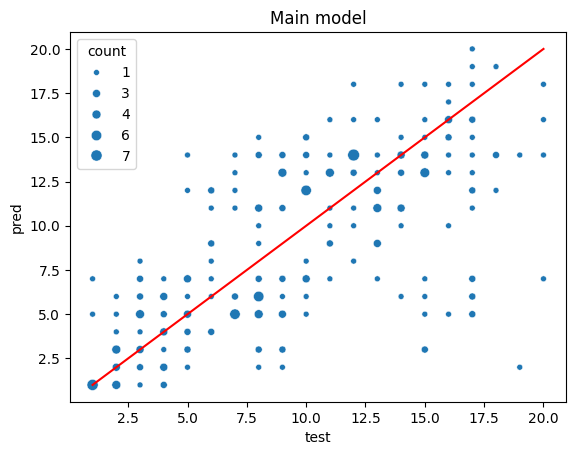

Accuracy of ensembled model: 0.11462450592885376
Custom top5 score: 0.2832999533328148


In [213]:
VC_model = VotingClassifier(estimators=[
    ("DecisionTree", dt_best),
    ("RandomForest", rf_best),
    ("ExtraTreesClassifier", et_best),
    ("GradientBoosting", gb_best),
    ("LinearDiscriminantAnalysis", lda_best)
], voting='soft')
VC_model.fit(x_train, y_train)
y_pred = VC_model.predict(x_test)
visualize(y_test, y_pred, label='Main model')
print("Accuracy of ensembled model:",accuracy_score(y_test, y_pred))
print("Custom top5 score:",top5_score_calculate(y_test, y_pred))


In [214]:
#Dumping the model so we can recreate same outcome and reduce running time

from joblib import dump, load
dump(VC_model, 'model.joblib') 


['model.joblib']

In [195]:
#loading the models
best_model = load('model.joblib')


In [196]:
#Creating excel to manually set data from the oncoming race
df = historic_performance[historic_performance['raceId'] == 1107].drop(['top5','positionNumber_race','raceId','year'], axis=1)
df.to_excel('parameterSetting.xlsx')
df

,driverId,rolling,streak_counter,courseLength,circuitType,stop,timeMillis,bestChampionshipPosition,totalChampionshipWins,totalRaceWins,totalPodiums,totalPolePositions,totalFastestLaps,pos_mean,gap_mean,driver_index
15676,esteban-ocon,11.000000,1,5.412,1,1.0,22663.0,8.0,0,1,3,0,0,12.500000,284.0,5
15675,nico-hulkenberg,10.800000,1,5.412,1,1.5,22771.0,7.0,0,0,0,1,2,9.750000,812.0,19
15673,oscar-piastri,7.600000,1,5.412,1,1.5,26312.5,9.0,0,0,2,0,3,5.000000,269.5,23
15683,max-verstappen,11.600000,1,5.412,1,1.0,22187.0,1.0,3,58,103,38,32,1.000000,0.0,16
15679,yuki-tsunoda,12.750000,1,5.412,1,1.0,22153.0,14.0,0,0,0,0,1,10.250000,706.0,29
15672,guanyu-zhou,6.400000,2,5.412,1,1.0,23017.0,18.0,0,0,0,0,2,15.750000,425.0,8
15678,george-russell,14.000000,1,5.412,1,1.0,22800.0,4.0,0,1,11,1,6,8.500000,507.5,7
15684,lando-norris,12.800000,1,5.412,1,1.0,22041.0,6.0,0,1,16,1,6,10.000000,626.5,12
15681,sergio-perez,13.000000,1,5.412,1,1.5,22045.5,2.0,0,6,39,3,11,4.000000,246.0,27
15669,lance-stroll,6.000000,1,5.412,1,1.5,22834.5,10.0,0,0,3,1,0,7.666667,111.0,11


In [224]:
imolaGP_driver = pd.read_excel('parameterSetting.xlsx', index_col=0)
imolaGP = imolaGP_driver.drop('driverId', axis=1)
imolaGP

,rolling,streak_counter,courseLength,circuitType,stop,timeMillis,bestChampionshipPosition,totalChampionshipWins,totalRaceWins,totalPodiums,totalPolePositions,totalFastestLaps,pos_mean,gap_mean,driver_index
15676,11.000000,1,5.412,1,1.0,22663.0,8,0,1,3,0,0,12.500000,284.0,5
15675,10.800000,1,5.412,1,1.5,22771.0,7,0,0,0,1,2,9.750000,812.0,19
15673,7.600000,1,5.412,1,1.5,26312.5,9,0,0,2,0,3,5.000000,269.5,23
15683,11.600000,1,5.412,1,1.0,22187.0,1,3,58,103,38,32,1.000000,0.0,16
15679,12.750000,1,5.412,1,1.0,22153.0,14,0,0,0,0,1,10.250000,706.0,29
15672,6.400000,2,5.412,1,1.0,23017.0,18,0,0,0,0,2,15.750000,425.0,8
15678,14.000000,1,5.412,1,1.0,22800.0,4,0,1,11,1,6,8.500000,507.5,7
15684,12.800000,1,5.412,1,1.0,22041.0,6,0,1,16,1,6,10.000000,626.5,12
15681,13.000000,1,5.412,1,1.5,22045.5,2,0,6,39,3,11,4.000000,246.0,27
15669,6.000000,1,5.412,1,1.5,22834.5,10,0,0,3,1,0,7.666667,111.0,11


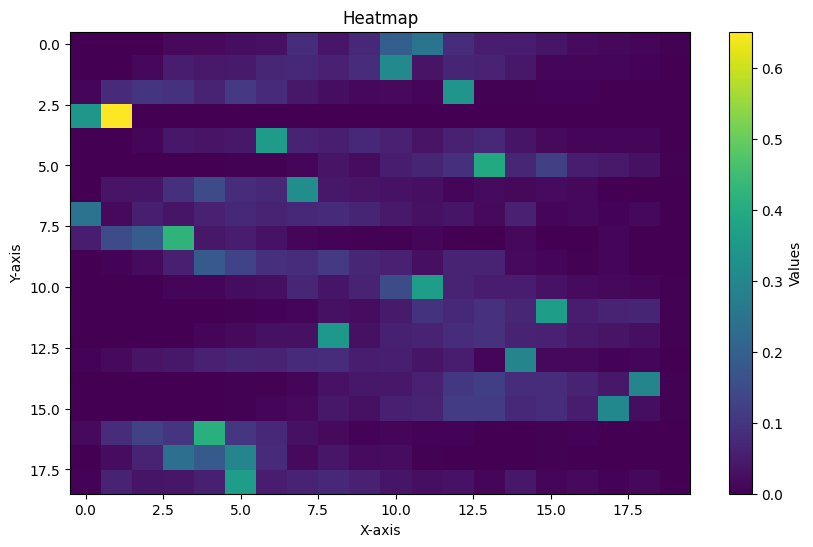

,driverId,prediction
15683,max-verstappen,1.703080
15681,sergio-perez,4.190070
15680,carlos-sainz-jr,5.063854
15682,charles-leclerc,5.590906
15684,lando-norris,6.952099


In [226]:
df = VC_model.predict_proba(imolaGP)
plt.figure(figsize=(10, 6))
plt.imshow(df, cmap='viridis', aspect='auto')
plt.colorbar(label='Values')
plt.title('Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


positions = np.arange(1, df.shape[1] + 1)

# Calculate weighted average of positions
imolaGP_driver['prediction'] = np.dot(df, positions)
imolaGP_final = imolaGP_driver.sort_values(by='prediction')
imolaGP_final[['driverId','prediction']].head()
